In [1]:
from __future__ import print_function
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# for compatible with python 3
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
import pandas as pd
#dataset = pd.read_csv("./data/training_data.csv",index_col=[0]) #Train csv
dataset = pd.read_csv("./data/total_after.csv",index_col=[0])  #Test csv

In [4]:
dataset.head()

,DataTime,Asia Bond open,Asia Bond high,Asia Bond low,Asia Bond close,Asia Bond volume,Asia Equity open,Asia Equity high,Asia Equity low,Asia Equity close,...,US Bond open,US Bond high,US Bond low,US Bond close,US Bond volume,US Equity open,US Equity high,US Equity low,US Equity close,US Equity volume
0,2005-03-01,0.973767,0.981128,0.969874,1.013158,1,0.960927,1.007458,0.887164,0.984855,...,0.991937,0.999604,0.979667,1.015329,1,0.978079,1.002785,0.957472,0.961276,1
1,2005-04-01,0.986580,0.999035,0.978498,1.019436,1,0.946374,1.033856,0.824377,0.987658,...,1.007142,1.038226,0.981557,1.025130,1,0.940204,0.996095,0.879653,1.009947,1
2,2005-05-01,0.992693,1.015119,0.979470,1.025670,1,0.949067,1.102155,0.792283,1.004014,...,1.016864,1.070787,0.981557,1.031456,1,0.987808,1.084371,0.892034,1.028592,1
3,2005-06-01,0.998764,1.023289,0.983919,1.022602,1,0.964784,1.150068,0.747567,1.048551,...,1.023139,1.093955,0.980621,1.021643,1,1.006044,1.139001,0.867061,1.081581,1
4,2005-07-01,0.995777,1.023800,0.977297,1.028888,1,1.007581,1.297207,0.727353,1.050129,...,1.013405,1.096059,0.947453,1.034439,1,1.057872,1.239699,0.888079,1.063765,1


In [5]:
dataset = dataset[dataset.DataTime>='2016-07-01'] #Test csv

In [6]:
abbreviation = pd.read_csv("data/symbols.txt")

In [7]:
abbreviation

,symbols
0,Asia Bond
1,Asia Equity
2,Creat China Equity
3,EmgMkt Bond
4,EmgMkt Equity
5,Europe Bond
6,Europe Equity
7,Global Bond
8,Global Equity
9,HY Bond


In [8]:
history = np.empty((15,len(dataset),5))

In [9]:
suffix = [" open", " close", " high", " low", " volume"]

In [10]:
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history[i_n, :, j_n] = dataset[i+j]

In [11]:
history.shape

(15, 35, 5)

In [12]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope

from environment.portfolio import PortfolioEnv

/Users/chu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [13]:
data={'ALL': dataset}

In [14]:
data['ALL'].shape

(35, 76)

In [15]:
history_Model = np.empty((15,35,5)) #Train 141 Test 35
for i_n, i in enumerate(abbreviation['symbols']):
     for j_n, j in enumerate(suffix):
            history_Model[i_n, :, j_n] = data["ALL"][i+j]

In [16]:
batch_size = 10
action_bound = 1.
tau = 1e-3
window_length = 6
predictor_type = 'lstm'
use_batch_norm = True
nb_classes = 15

In [17]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "./weights/stock/lstm/window_6/batch_norm/checkpoint.ckpt_Episode_1700/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.




Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./weights/stock/lstm/window_6/batch_norm/checkpoint.ckpt_Episode_1700/checkpoint.ckpt


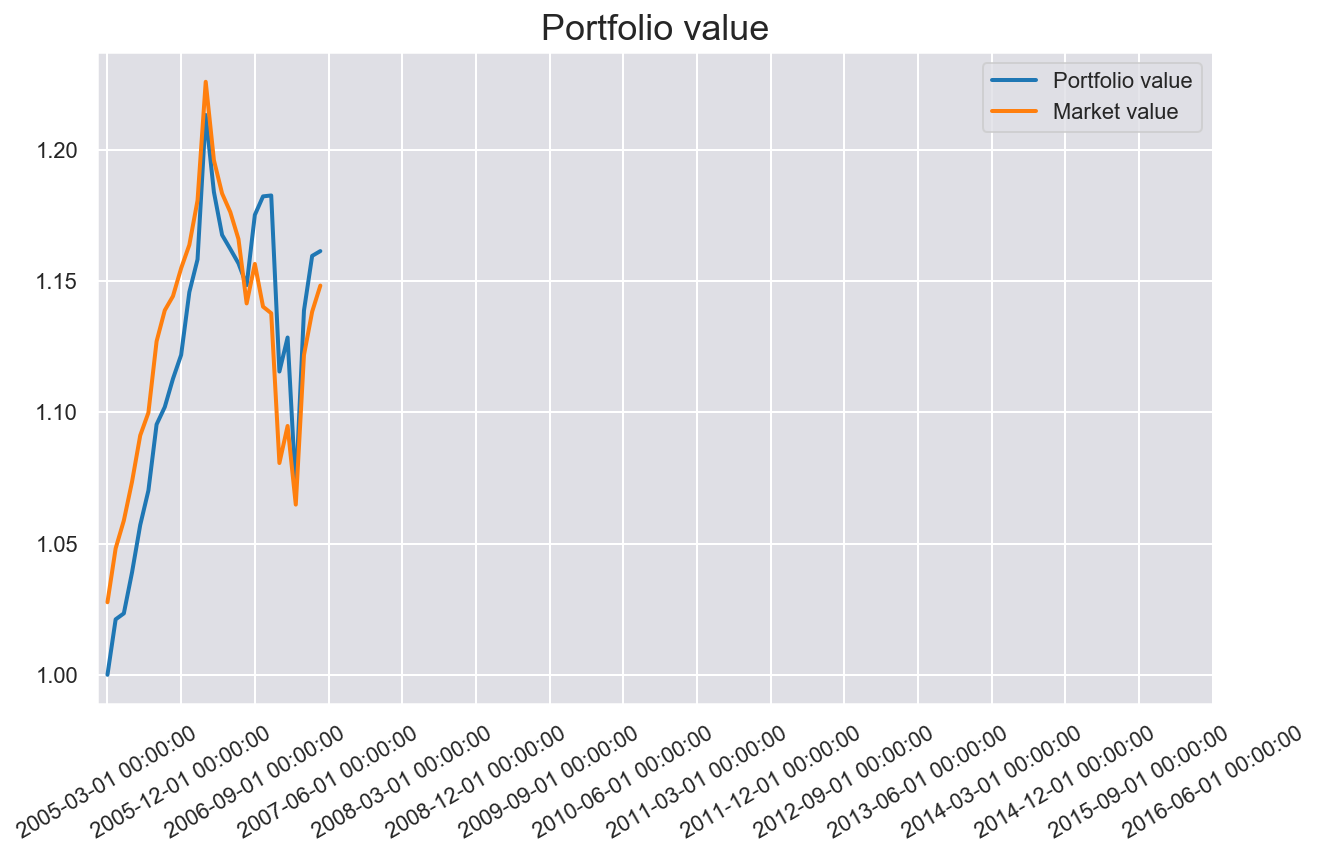

In [18]:
from environment.portfolio import PortfolioEnv
env_Model = PortfolioEnv(history_Model, abbreviation, steps=history_Model.shape[1]-8, window_length=6,
                        start_idx=data['ALL'].DataTime.iloc[0])
test_model(env_Model, ddpg_model)

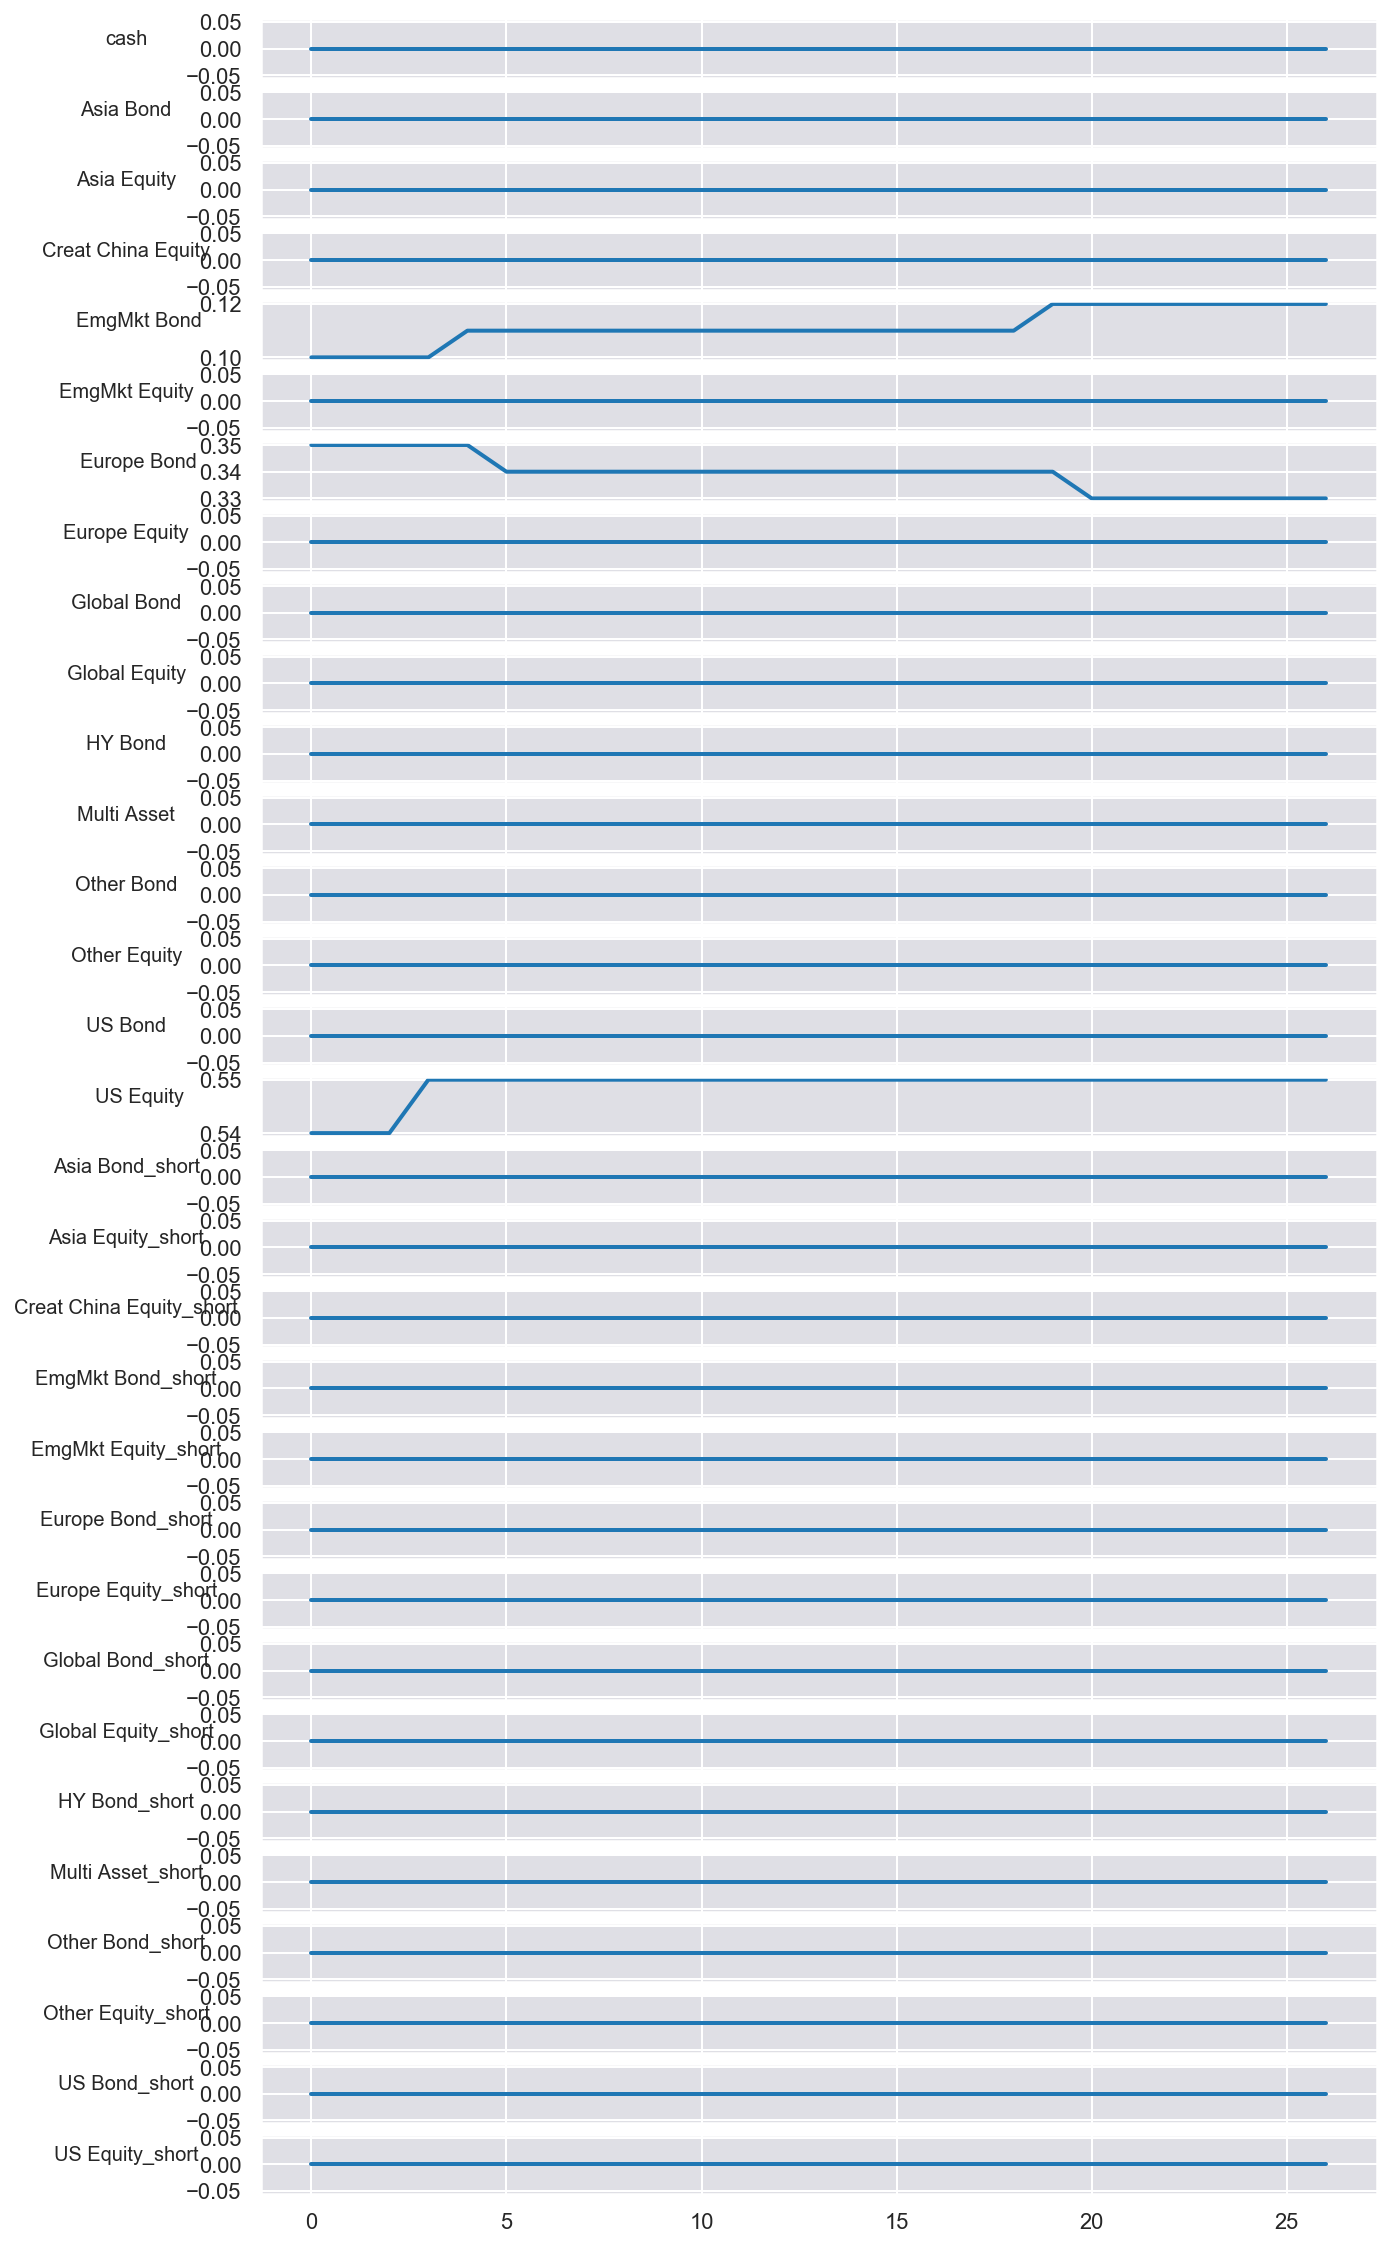

In [19]:
def plot_weights(env_infos):
    weights_change = np.empty((31,len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation.iloc[:, 0])
    short_position = []
    for i in long_position:
        short_position.append(i + '_short')
    ylabel = ['cash'] + long_position + short_position
    plt.figure(figsize=(10,20))
    for i in range(31):
        plt.subplot(31, 1, i+1)
        plt.plot(np.round(weights_change[i, :], decimals=2))
        h = plt.ylabel(ylabel[i], fontsize = 10, labelpad=30)
        h.set_rotation(0)
plot_weights(env_Model.infos)